<a href="https://colab.research.google.com/github/mitali-dxt/CurveRefiner/blob/master/CurveRefiner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [201]:
# regularization.py
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.spatial import distance
from sklearn.linear_model import LinearRegression
from scipy.optimize import least_squares
from sklearn.preprocessing import PolynomialFeatures
from skimage.measure import EllipseModel
import cv2

def regularize_line(points):
    if len(points) < 2:
        return points
    # Keep the start and end points the same
    start_point = points[0]
    end_point = points[-1]
    total_distance = np.linalg.norm(end_point - start_point)
    # Calculate the direction vector for the straight line
    direction = (end_point - start_point) / total_distance
    # Generate new points along the straight line
    new_points = []
    for i in range(len(points)):
        # Calculate the distance from the start point for the current point
        current_distance = np.linalg.norm(points[i] - start_point)
        # Calculate the new point along the straight line
        new_point = start_point + current_distance * direction
        new_points.append(new_point)
    return np.array(new_points)

def regularize_circle(points):
    if len(points) < 3:
        return points
    def calc_R(xc, yc):
        return np.sqrt((points[:, 0] - xc) ** 2 + (points[:, 1] - yc) ** 2)
    def residuals(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()
    center_estimate = np.mean(points, axis=0)
    center = least_squares(residuals, center_estimate).x
    Ri = calc_R(*center)
    R = Ri.mean()
    theta = np.linspace(0, 2 * np.pi, len(points))
    x_fit = center[0] + R * np.cos(theta)
    y_fit = center[1] + R * np.sin(theta)
    return np.column_stack((x_fit, y_fit))

def regularize_rectangle(points):
    if len(points) < 4:
        return points
    x_min, y_min = np.min(points, axis=0)
    x_max, y_max = np.max(points, axis=0)
    rect_points = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max], [x_min, y_min]])
    return rect_points

def regularize_square(points):
    if len(points) < 4:
        return points
    x_min, y_min = np.min(points, axis=0)
    x_max, y_max = np.max(points, axis=0)
    side = max(x_max - x_min, y_max - y_min)
    sqr_points = np.array([[x_min, y_min], [x_min + side, y_min], [x_min + side, y_min + side], [x_min, y_min + side], [x_min, y_min]])
    return sqr_points


def find_star_vertices(points, angle_threshold=0.1):
    vertices = []
    num_points = len(points)
    for i in range(num_points):
        p1 = points[i]
        p2 = points[(i + 1) % num_points]
        p3 = points[(i + 2) % num_points]
        # Vectors
        v1 = p2 - p1
        v2 = p3 - p2
        # Compute angle between vectors
        angle = np.arccos(np.clip(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1.0, 1.0))
        if angle > angle_threshold:
            vertices.append(p2)
    return vertices


def regularize_star(points):
    vertices = find_star_vertices(points)
    # Create an ordered list of vertices
    ordered_vertices = np.array(vertices)
    ordered_vertices = np.append(ordered_vertices, [ordered_vertices[0]], axis=0)  # Close the shape
    return ordered_vertices


def regularize_ellipse(points):
    if len(points) < 5:
        return points

    # Fit ellipse using OpenCV
    ellipse_params = cv2.fitEllipse(np.array(points, dtype=np.float32))
    center, (major_axis, minor_axis), angle = ellipse_params

    # Generate ellipse points
    theta = np.linspace(0, 2 * np.pi, len(points))
    a = major_axis / 2
    b = minor_axis / 2
    x0, y0 = center

    x_fit = x0 + a * np.cos(theta) * np.cos(np.deg2rad(angle)) - b * np.sin(theta) * np.sin(np.deg2rad(angle))
    y_fit = y0 + a * np.cos(theta) * np.sin(np.deg2rad(angle)) + b * np.sin(theta) * np.cos(np.deg2rad(angle))

    return np.column_stack((x_fit, y_fit))

def regularize_saturn_ring(points):
    if len(points) < 10:
        return points

    # Fit the main ellipse for Saturn's body
    body_ellipse = regularize_ellipse(points)

    # Generate additional rings
    num_rings = 3
    ring_width = 0.1
    ring_ellipses = []
    for i in range(num_rings):
        scale = 1 + i * ring_width
        ring_ellipse = body_ellipse * scale
        ring_ellipses.append(ring_ellipse)

    return np.vstack([body_ellipse] + ring_ellipses)

In [165]:
# symmetry.py
import numpy as np

def detect_symmetry(points):
    reflectional_symmetry_lines = detect_reflectional_symmetry_lines(points)
    rotational_symmetry_lines_180 = detect_rotational_symmetry_lines(points, np.pi)  # 180 degrees
    rotational_symmetry_lines_90 = detect_rotational_symmetry_lines(points, np.pi / 2)  # 90 degrees
    symmetry_results = {
        "Reflectional Symmetry Lines": reflectional_symmetry_lines,
        "Rotational Symmetry Lines (180°)": rotational_symmetry_lines_180,
        "Rotational Symmetry Lines (90°)": rotational_symmetry_lines_90,
    }
    return symmetry_results

def detect_reflectional_symmetry_lines(points):
    centroid = np.mean(points, axis=0)
    count = 0
    for angle in np.linspace(0, np.pi, 180):  # Test every 1 degree
        reflection_matrix = np.array([
            [np.cos(2 * angle), np.sin(2 * angle)],
            [np.sin(2 * angle), -np.cos(2 * angle)]
        ])
        reflected_points = np.dot(points - centroid, reflection_matrix) + centroid
        sorted_points = np.sort(points, axis=0)
        sorted_reflected = np.sort(reflected_points, axis=0)
        differences = np.linalg.norm(sorted_points - sorted_reflected, axis=1)
        if np.all(differences < 1e-6):
            count += 1
    return count

def detect_rotational_symmetry_lines(points, angle):
    centroid = np.mean(points, axis=0)
    count = 0
    for i in range(0, 360, int(np.degrees(angle))):
        rad_angle = np.radians(i)
        rotation_matrix = np.array([
            [np.cos(rad_angle), -np.sin(rad_angle)],
            [np.sin(rad_angle),  np.cos(rad_angle)]
        ])
        rotated_points = np.dot(points - centroid, rotation_matrix.T) + centroid
        sorted_points = np.sort(points, axis=0)
        sorted_rotated = np.sort(rotated_points, axis=0)
        differences = np.linalg.norm(sorted_points - sorted_rotated, axis=1)
        if np.all(differences < 1e-6):
            count += 1
    return count

In [145]:
#completion.py
import numpy as np
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

def handle_disconnected_occlusions(points):
    if len(points) < 2:
        return points
    start_point = points[0]
    end_point = points[-1]
    lin_reg = LinearRegression()
    lin_reg.fit(points[:, 0].reshape(-1, 1), points[:, 1])
    new_x = np.linspace(start_point[0], end_point[0], num=500)
    new_y = lin_reg.predict(new_x.reshape(-1, 1))
    completed_points = np.vstack((points, np.column_stack((new_x, new_y))))
    return completed_points

def complete_curve(points, occlusion_type='connected'):
    if occlusion_type == 'connected':
        x = points[:, 0]
        y = points[:, 1]
        f = interp1d(x, y, kind='linear')
        new_x = np.linspace(x[0], x[-1], num=500)
        new_y = f(new_x)
        completed_points = np.column_stack((new_x, new_y))
        return completed_points
    elif occlusion_type == 'disconnected':
        completed_points = handle_disconnected_occlusions(points)
        return completed_points

Reflectional Symmetry Lines: 0
Rotational Symmetry Lines (180°): 1
Rotational Symmetry Lines (90°): 1
line_prob: 0, circle_prob: 0.9368127714475485, rectangle_prob: 0, square_prob: 0, star_prob: 0
Shape has 1 rotational symmetry lines at 180°.
Shape has 1 rotational symmetry lines at 90°.
Reflectional Symmetry Lines: 0
Rotational Symmetry Lines (180°): 1
Rotational Symmetry Lines (90°): 1
line_prob: 0, circle_prob: 0.22569510488613986, rectangle_prob: 0, square_prob: 0, star_prob: 1
Shape has 1 rotational symmetry lines at 180°.
Shape has 1 rotational symmetry lines at 90°.
Reflectional Symmetry Lines: 0
Rotational Symmetry Lines (180°): 1
Rotational Symmetry Lines (90°): 1
line_prob: 0, circle_prob: 0.7838910327277219, rectangle_prob: 0.0, square_prob: 1, star_prob: 0
Shape has 1 rotational symmetry lines at 180°.
Shape has 1 rotational symmetry lines at 90°.


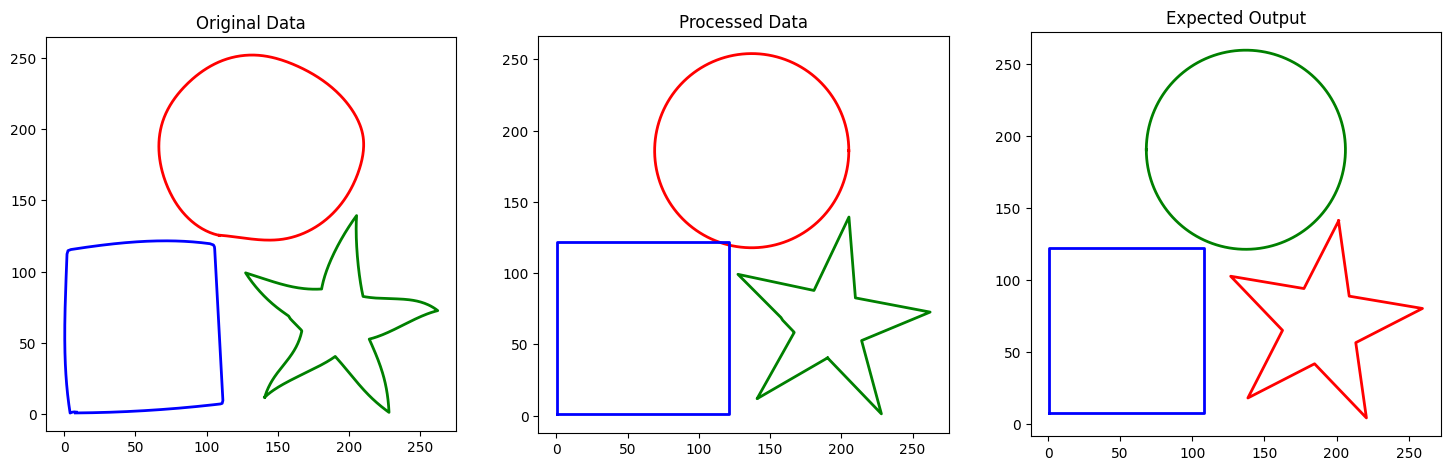

In [261]:
# main-file
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.spatial import distance
from sklearn.linear_model import LinearRegression
from scipy.optimize import least_squares
from sklearn.preprocessing import PolynomialFeatures
from skimage.measure import EllipseModel
from sklearn.linear_model import RANSACRegressor
from sklearn.pipeline import make_pipeline
import cv2
#from symmetry import detect_symmetry

def read_csv_(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def get_contour(points):
    points = points.reshape((-1, 1, 2)).astype(np.int32)
    # Get the contour using OpenCV
    contour = cv2.approxPolyDP(points, 0.02 * cv2.arcLength(points, True), True)
    return contour.reshape(-1, 2)  # Flatten contour to a 2D array

def is_right_angle(v1, v2):
    """Check if the angle between vectors v1 and v2 is close to 90 degrees"""
    v1 = v1.flatten()
    v2 = v2.flatten()
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    cosine_angle = dot_product / (magnitude_v1 * magnitude_v2)
    return np.isclose(cosine_angle, 0, atol=1e-2)

def similarity_rectangle(points):
    if len(points) < 4:
        return 0
    contour = get_contour(points)
    if len(contour) != 4:
        return 0
    v1 = contour[1] - contour[0]
    v2 = contour[2] - contour[1]
    v3 = contour[3] - contour[2]
    v4 = contour[0] - contour[3]
    angles = [
        is_right_angle(v1, v2),
        is_right_angle(v2, v3),
        is_right_angle(v3, v4),
        is_right_angle(v4, v1)
    ]
    angle_score = sum(angles) / len(angles)
    side_lengths = [
        np.linalg.norm(v1),
        np.linalg.norm(v2),
        np.linalg.norm(v3),
        np.linalg.norm(v4)
    ]
    length_score = (
        (np.isclose(side_lengths[0], side_lengths[2], atol=1e-2) +
         np.isclose(side_lengths[1], side_lengths[3], atol=1e-2)) / 2
    )
    # Overall similarity score
    overall_score = (angle_score + length_score) / 2
    return overall_score

def calculate_angle(p1, p2, p3):
    v1 = np.array(p2) - np.array(p1)
    v2 = np.array(p3) - np.array(p2)
    angle = np.degrees(np.arccos(np.clip(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1.0, 1.0)))
    return angle

def similarity_line(points, angle_threshold=167):
    if len(points) < 2:
        return 0
    contour = get_contour(points)
    # Check contour length
    if len(contour) == 2:
        return 1
    if len(contour) == 3:
        p1, p2, p3 = contour[0], contour[1], contour[2]
        angle = calculate_angle(p1, p2, p3)
        # Check if the angle is greater than the threshold
        if 180-angle > angle_threshold:
            return 1
    return 0

def similarity_circle(points):
    if len(points) < 3:
        return 0
    contour = get_contour(points)
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    circularity = 4 * np.pi * (area / (perimeter * perimeter))
    return circularity

def similarity_square(points):
    if len(points) < 4:
        return 0
    # Convert points to a contour format
    contour = np.array(points, dtype=np.int32).reshape((-1, 1, 2))
    contour = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
    if len(contour) != 4:
        return 0
    # Compute bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)
    # Compute aspect ratio to check if the shape is a square
    aspect_ratio = w / float(h)
    # Check if aspect ratio is close to 1 (indicating a square)
    if 0.9 <= aspect_ratio <= 1.1:
        return 1
    return 0

def similarity_star(points):
    contour = get_contour(points)
    if len(contour)==10:
      return 1
    if len(points) < 5:
        return 0
    contour = np.array(points, dtype=np.int32).reshape((-1, 1, 2))
    contour = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
    hull = cv2.convexHull(contour, returnPoints=False)
    if hull.size == 0:
        return 0
    try:
        defects = cv2.convexityDefects(contour, hull)
        if defects is None:
            return 0
        num_defects = 0
        for i in range(defects.shape[0]):
            s, e, f, d = defects[i, 0]
            start = tuple(contour[s][0])
            end = tuple(contour[e][0])
            far = tuple(contour[f][0])
            a = np.linalg.norm(np.array(start) - np.array(end))
            b = np.linalg.norm(np.array(start) - np.array(far))
            c = np.linalg.norm(np.array(end) - np.array(far))
            angle = np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c))
            if angle <= np.pi / 2:  # angle less than 90 degrees
                num_defects += 1
        return 1 if num_defects == 5 else 0
    except cv2.error as e:
        print(f"OpenCV error: {e}")
        return 0

#def similarity_ellipse(points):
    #if len(points) < 5:
       # return 0

    #try:
        # Convert points to the format expected by OpenCV

        #points = np.array(points, dtype=np.float32).reshape(-1, 1, 2)

        # Fit an ellipse to the points using OpenCV
        #ellipse = cv2.fitEllipse(points)
        #center, (major_axis, minor_axis), angle = ellipse

        # Convert diameters to radii
       # major_axis /= 2
       # minor_axis /= 2

        # Check if the axes are reasonably different
        #if major_axis < 1e-2 or minor_axis < 1e-2:
           # return 0  # One of the axes is too small to be a valid ellipse

        # Avoid nearly circular shapes
       # aspect_ratio = major_axis / minor_axis
       # if aspect_ratio < 0.8 or aspect_ratio > 1.2:
            # Check if the aspect ratio is close to 1 (which would indicate a circle)
           # pass
       # else:
          #  return 0  # The aspect ratio indicates a near-circle

        # Generate ellipse points
       # theta = np.linspace(0, 2 * np.pi, 100)
       # x_fit = center[0] + major_axis * np.cos(theta) * np.cos(np.deg2rad(angle)) - minor_axis * np.sin(theta) * np.sin(np.deg2rad(angle))
      #  y_fit = center[1] + major_axis * np.cos(theta) * np.sin(np.deg2rad(angle)) + minor_axis * np.sin(theta) * np.cos(np.deg2rad(angle))
      #  ellipse_fit = np.column_stack((x_fit, y_fit))

        # Compute the fitting error
      #  distances = np.linalg.norm(points[:, 0, :] - ellipse_fit[:, None], axis=2)
      #  min_distances = np.min(distances, axis=1)
      #  error = np.mean(min_distances)

        # Define a threshold for similarity
      #  threshold = 5  # Adjust this threshold based on your specific requirements
      #  return 1 if error < threshold else 0

   # except Exception as e:
       # print(f"Error fitting ellipse: {e}")
       # return 0

def process_shapes(paths_XYs, threshold=0.74):
    processed_paths = []
    for path in paths_XYs:
        for points in path:
            if len(points) < 2:
                continue

            # Calculate symmetry lines
            symmetry_info = detect_symmetry(points)
            reflectional_lines = symmetry_info["Reflectional Symmetry Lines"]
            rotational_lines_180 = symmetry_info["Rotational Symmetry Lines (180°)"]
            rotational_lines_90 = symmetry_info["Rotational Symmetry Lines (90°)"]

            print(f"Reflectional Symmetry Lines: {reflectional_lines}")
            print(f"Rotational Symmetry Lines (180°): {rotational_lines_180}")
            print(f"Rotational Symmetry Lines (90°): {rotational_lines_90}")

            # Calculate similarity probabilities for different shapes
            line_prob = similarity_line(points)
            circle_prob = similarity_circle(points)
            rectangle_prob = similarity_rectangle(points)
            square_prob = similarity_square(points)
            star_prob = similarity_star(points)
           # ellipse_prob = similarity_ellipse(points)

            # Determine the maximum similarity probability
            max_prob = max(line_prob, circle_prob, rectangle_prob, square_prob, star_prob)#, ellipse_prob)

            print(f"line_prob: {line_prob}, circle_prob: {circle_prob}, rectangle_prob: {rectangle_prob}, square_prob: {square_prob}, star_prob: {star_prob}")#, ellipse_prob: {ellipse_prob}")

            # Regularize the shape based on the highest similarity probability
            if max_prob < threshold:
                processed_paths.append([points])
            elif max_prob == line_prob:
                processed_paths.append([regularize_line(points)])
            elif max_prob == circle_prob:
                processed_paths.append([regularize_circle(points)])
            elif max_prob == rectangle_prob:
                processed_paths.append([regularize_rectangle(points)])
            elif max_prob == square_prob:
                processed_paths.append([regularize_square(points)])
            elif max_prob == star_prob:
                processed_paths.append([regularize_star(points)])
            #elif max_prob == ellipse_prob:
               # processed_paths.append([regularize_ellipse(points)])


            # If symmetry lines are detected, you can further process them as needed
            if reflectional_lines > 0:
                print(f"Shape has {reflectional_lines} reflectional symmetry lines.")
            if rotational_lines_180 > 0:
                print(f"Shape has {rotational_lines_180} rotational symmetry lines at 180°.")
            if rotational_lines_90 > 0:
                print(f"Shape has {rotational_lines_90} rotational symmetry lines at 90°.")

    return processed_paths

def plot(paths_XYs, title, ax):
    colours = ['red', 'green', 'blue', 'yellow', 'purple', 'cyan', 'magenta']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    ax.set_title(title)

csv_path1 = "isolated.csv"
csv_path2 = "isolated_sol.csv"

output_data1 = read_csv_(csv_path1)
expected_output_data = read_csv_(csv_path2)

processed_data = process_shapes(output_data1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

plot(output_data1, "Original Data", ax1)
plot(processed_data, "Processed Data", ax2)
plot(expected_output_data, "Expected Output", ax3)

plt.show()